In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gamma, truncnorm, norm, dirichlet

In [12]:
dirichlet.rvs(np.array([0.3, 0.7]))

array([[0.03248746, 0.96751254]])

(array([1.049e+03, 4.980e+02, 2.410e+02, 1.170e+02, 5.300e+01, 2.100e+01,
        1.600e+01, 2.000e+00, 1.000e+00, 2.000e+00]),
 array([3.57540907e-06, 2.48115073e-02, 4.96194392e-02, 7.44273710e-02,
        9.92353029e-02, 1.24043235e-01, 1.48851167e-01, 1.73659099e-01,
        1.98467030e-01, 2.23274962e-01, 2.48082894e-01]),
 <BarContainer object of 10 artists>)

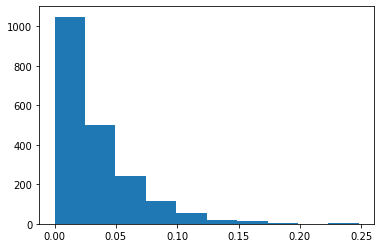

In [34]:
# simulate data from a known mixture distribution
np.random.seed(12345)  # set random seed for reproducibility

k = 1
ndata = 1000
# spread = 5
# centers = np.array([-spread, 0, spread])

# simulate data from mixture distribution

v = np.random.randint(0, k, ndata)
data_1 = np.random.gamma(shape = 1, scale = 1/30, size = ndata)
data_2 = np.random.gamma(shape = 1, scale = 1/30, size = ndata)

data = np.append(data_1, data_2)
plt.hist(data)

In [35]:
def log_mpgd_posterior_kernel(data, p, mu, eta, u, csi, sigma, a_prior, b_prior, c_prior, d_prior, mu_u, sigma_u):
    '''
    data: observed values
    p: mixture weights
    mu: mean vector from gamma mixture
    eta: shape vector from gamma mixture
    u: threshold value from extreme values represented as the GPD parameter
    csi: GPD parameter
    sigma: GPD parameter
    a_prior: prior parameter vector from IG distribution over mu
    b_prior: prior parameter vector from IG distribution over mu
    c_prior: prior parameter vector from gamma distribution over eta
    d_prior: prior parameter vector from gamma distribution over eta
    mu_u: prior mean over u
    sigma_u: prior scale over u
    '''
    data_under_u = data[data < u]
    data_over_u = data[data >= u]
    
    # gamma mixture kernel
    gm_kernel = 0
    for j in range(len(p)):
        gm_kernel += np.log(p[j] * gamma.pdf(x = data_under_u, a = eta[j], scale = eta[j] / mu[j])).sum()
        
        # cumulated
        cumulated_prob = p[j] * gamma.cdf(u, a = eta[j], scale = eta[j] / mu[j])
        
    # generalized pareto distribution kernel 
    log_cumulated_prob = len(data_over_u) * np.log(1 - cumulated_prob)
    
    gpd_kernel = (log_cumulated_prob
                - np.sum(np.log(sigma) - ((1 + csi)/csi) * np.log1p(csi * (data_over_u - u)/sigma)
                + np.sum((c_prior - 1) * np.log(eta) -  d_prior * eta  - (a_prior + 1) * np.log(mu) - b_prior/mu)
                - 0.5*((u - mu_u)/sigma_u)**2 - np.log(sigma) - np.log(1+csi)
                - 0.5 * np.log(1 + 2*csi)))
                  
    return gm_kernel + gpd_kernel

In [91]:
def metropolis_step(prop, current, posterior_kernel, proposed_kernel):
    '''
    log scaled only for both posterior kernel and proposed kernel
    
    prop: proposed value
    current: current value
    posterior_kernel: dict with posterior kernel both under prop and current value
    proposed_kernel: dict proposed kernel with both under prop and current value
    '''
    ratio = (posterior_kernel['prop'] + proposed_kernel['current'])/(posterior_kernel['current'] + proposed_kernel['prop'])
    prob = min(1, ratio)
    
    rand = np.random.random_sample(1)
    if rand < prob:
        return prop
    else:
        return current

In [92]:
def draw_csi(csi, *args):
    
    inf_limit = -sigma[s]/(M - u[s])
    sup_limit = np.inf
    csi_posterior_kernel = {}
    csi_proposed_kernel = {}

    csi_potential = truncnorm.rvs(a = inf_limit, b = sup_limit, loc=csi[s], scale=v_csi, size=1)

    csi_posterior_kernel['current'] = log_mpgd_posterior_kernel(data, p[s], mu[s], eta[s], u[s], 
                                                                csi[s], sigma[s], prior_values['a_prior'], 
                                                                prior_values['b_prior'], prior_values['c_prior'], 
                                                                prior_values['d_prior'], prior_values['mu_u'], 
                                                                prior_values['sigma_u'])

    csi_posterior_kernel['prop'] = log_mpgd_posterior_kernel(data, p[s], mu[s], eta[s], u[s], 
                                                                csi_potential, sigma[s], prior_values['a_prior'], 
                                                                prior_values['b_prior'], prior_values['c_prior'], 
                                                                prior_values['d_prior'], prior_values['mu_u'], 
                                                                prior_values['sigma_u'])

    csi_proposed_kernel['current'] = norm.logpdf(x = np.sqrt(v_csi)*(csi[s] + sigma[s])/(M - u[s])) 
    csi_proposed_kernel['prop'] = norm.logpdf(x = np.sqrt(v_csi)*(csi_potential + sigma[s])/(M - u[s]))

    csi_metropolis_output = metropolis_step(csi_potential, csi[s], csi_posterior_kernel, csi_proposed_kernel)
    csi = np.insert(csi, obj = csi.shape[0], values = [csi_metropolis_output], axis = 0)
    return csi

In [109]:
def fit(n_iteration, data, k, prior_values):
                
    #set initial values
    p = np.array([[(1/k)]*k], dtype = np.float32)
    mu = np.array([[0]*k], dtype = np.float32)
    eta = np.array([[0]*k], dtype = np.float32)
    u = np.array([[1]], dtype = np.float32)
    csi = np.array([[1]], dtype = np.float32)
    sigma = np.array([[1]], dtype = np.float32)
    
    # latent values
    M = max(data)
    v_csi = 1
    
    for s in range(n_iteration):
        #TODO: define a different confunction for each parameter
        # draw from csi
        inf_limit = -sigma[s]/(M - u[s])
        sup_limit = np.inf
        csi_posterior_kernel = {}
        csi_proposed_kernel = {}
        print(csi)
        csi_potential = truncnorm.rvs(a = inf_limit, b = sup_limit, loc=csi[s], scale=v_csi, size=1)
        print(csi_potential)
        csi_posterior_kernel['current'] = log_mpgd_posterior_kernel(data, p[s], mu[s], eta[s], u[s], 
                                                                    csi[s], sigma[s], prior_values['a_prior'], 
                                                                    prior_values['b_prior'], prior_values['c_prior'], 
                                                                    prior_values['d_prior'], prior_values['mu_u'], 
                                                                    prior_values['sigma_u'])
        
        csi_posterior_kernel['prop'] = log_mpgd_posterior_kernel(data, p[s], mu[s], eta[s], u[s], 
                                                                    csi_potential, sigma[s], prior_values['a_prior'], 
                                                                    prior_values['b_prior'], prior_values['c_prior'], 
                                                                    prior_values['d_prior'], prior_values['mu_u'], 
                                                                    prior_values['sigma_u'])
        
        csi_proposed_kernel['current'] = norm.logpdf(x = np.sqrt(v_csi)*(csi[s] + sigma[s])/(M - u[s])) 
        csi_proposed_kernel['prop'] = norm.logpdf(x = np.sqrt(v_csi)*(csi_potential + sigma[s])/(M - u[s]))
        
        csi_metropolis_output = metropolis_step(csi_potential, csi[s], csi_posterior_kernel, csi_proposed_kernel)
        csi = np.insert(csi, obj = csi.shape[0], values = csi_metropolis_output, axis = 0)
        
        #draw from sigma
        
        #draw from u
        
        #draw from (mu_j, eta_j)
        
        #draw from p
        

In [110]:
prior_values = {}
prior_values['a_prior'] = 1
prior_values['b_prior'] = 1
prior_values['c_prior'] = 1                                         
prior_values['d_prior'] = 1
prior_values['mu_u'] = 1
prior_values['sigma_u'] = 1


fit(10, data, k=2, prior_values = prior_values)

[[1.]]
[2.57133538]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in float_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in float_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide


array([[1.       ],
       [2.5713353]], dtype=float32)